 Il est fort probable que la colonne adresse_station contienne des chaînes non uniformes ou incomplètes, rendant difficile l'extraction correcte des villes ou départements. Pour étudier cela proprement, on doit proceder ainsi:

---
---

### 🧠 Objectif final

* Déterminer **le meilleur champ** (`adresse_station`, `nom_commune`, `code_insee_commune`) pour filtrer efficacement les villes.
* Corriger le code de génération des heatmaps pour **fiabiliser la sélection des données** par ville.

On dispose des coordonnées géo (latitude+long). Mais on a préféré ne pas utiliser `geopy` ou `OpenStreetMap` pour géocoder automatiquement les adresses. Et ce pour des considérations des limitations imposées et de coût.

### 🔬 Étude de la qualité des adresses et de leur impact sur la géolocalisation par ville

#### Étape 1 : Chargement et prétraitement



In [1]:
import sys
import os

# Chemin absolu ou relatif vers le dossier racine du projet (qui contient le dossier geocharge)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [11]:
from geocharge.preprocessing import load_data, clean_data
from geocharge.regions import extract_departement, filter_by_ville
from geocharge.analysis import count_stations
from geocharge.visualization import generate_map, generate_heatmap

In [8]:
import pandas as pd
from dbfread import DBF

# Lecture du fichier DBF
dbf_path = "../data/raw/v_commune_2023.dbf"

# Tentative avec 'latin-1'
try:
    insee_records = DBF(dbf_path, load=True, encoding='latin-1')
    df_insee = pd.DataFrame(iter(insee_records))
    print("Fichier lu avec succès en latin-1!")
    print(df_insee.head())

except UnicodeDecodeError:
    print("Erreur de décodage avec latin-1. Tentative avec 'cp1252'...")
    # Tentative avec 'cp1252' si 'latin-1' échoue
    try:
        insee_records = DBF(dbf_path, load=True, encoding='cp1252')
        df_insee = pd.DataFrame(iter(insee_records))
        print("Fichier lu avec succès en cp1252!")
        print(df_insee.head())
    except UnicodeDecodeError as e:
        print(f"Erreur de décodage avec cp1252 également: {e}")
        print("Veuillez essayer d'autres encodages comme 'utf-8' ou 'iso-8859-15'.")
    except Exception as e:
        print(f"Une autre erreur est survenue lors de la lecture: {e}")

except Exception as e:
    print(f"Une autre erreur est survenue lors de la lecture: {e}")

Fichier lu avec succès en latin-1!
  TYPECOM    COM REG DEP CTCD  ARR TNCC                    NCC  \
0     COM  01001  84  01  01D  012    5  ABERGEMENT CLEMENCIAT   
1     COM  01002  84  01  01D  011    5    ABERGEMENT DE VAREY   
2     COM  01004  84  01  01D  011    1      AMBERIEU EN BUGEY   
3     COM  01005  84  01  01D  012    1    AMBERIEUX EN DOMBES   
4     COM  01006  84  01  01D  011    1                AMBLEON   

                  NCCENR                  LIBELLE   CAN COMPARENT  
0  Abergement-Clémenciat  L'Abergement-Clémenciat  0108            
1    Abergement-de-Varey    L'Abergement-de-Varey  0101            
2      Ambérieu-en-Bugey        Ambérieu-en-Bugey  0101            
3    Ambérieux-en-Dombes      Ambérieux-en-Dombes  0122            
4                Ambléon                  Ambléon  0104            


In [9]:
df_insee.head()

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
0,COM,01001,84,01,01D,012,5,ABERGEMENT CLEMENCIAT,Abergement-Clémenciat,L'Abergement-Clémenciat,0108,
1,COM,01002,84,01,01D,011,5,ABERGEMENT DE VAREY,Abergement-de-Varey,L'Abergement-de-Varey,0101,
2,COM,01004,84,01,01D,011,1,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,
3,COM,01005,84,01,01D,012,1,AMBERIEUX EN DOMBES,Ambérieux-en-Dombes,Ambérieux-en-Dombes,0122,
4,COM,01006,84,01,01D,011,1,AMBLEON,Ambléon,Ambléon,0104,


In [14]:
print(df["code_insee_commune"].unique())

['00nan' '38210.0' '63170.0' '47200.0' '64230.0' '64140.0' '6088.0'
 '13000.0' '69002.0' '28330.0' '69390.0' '38300.0' '26800.0' '34500.0'
 '69250.0' '34062.0' '42400.0' '73140.0' '68224.0' '26400.0' '42600.0'
 '71150.0' '88000.0' '71200.0' '42153.0' '13170.0' '42340.0' '41046.0'
 '1960.0' '71100.0' '38760.0' '42440.0' '57463.0' '83800.0' '68110.0'
 '71700.0' '42800.0' '69550.0' '38320.0' '42218.0' '69260.0' '69170.0'
 '67073.0' '80100.0' '87000.0' '31100.0' '56600.0' '21300.0' '31150.0'
 '31520.0' '30918.0' '37520.0' '31000.0' '13090.0' '16430.0' '31130.0'
 '83600.0' '26000.0' '79800.0' '85250.0' '31450.0' '42000.0' '85260.0'
 '68300.0' '34000.0' '84000.0']


In [11]:
df.shape

(11027, 42)

In [4]:
# === IMPORTS ===
import pandas as pd
from dbfread import DBF
from geocharge.preprocessing import load_data, clean_data

# === CHEMINS VERS LES FICHIERS ===
CSV_PATH = "../data/raw/1-irve-statique.csv"
INSEE_DBF_PATH = "../data/raw/v_commune_2023.dbf"

# === CHARGEMENT DES DONNÉES PRINCIPALES ===
df = load_data(CSV_PATH)
df = clean_data(df)

# === CHARGEMENT ROBUSTE DES DONNÉES INSEE ===
encodings_to_try = ['latin-1', 'cp1252', 'iso-8859-15']
df_insee = None
for enc in encodings_to_try:
    try:
        print(f"Tentative de lecture DBF avec l'encodage : {enc}")
        insee_records = DBF(INSEE_DBF_PATH, load=True, encoding=enc)
        df_insee = pd.DataFrame(iter(insee_records))
        print(f"✅ Lecture réussie avec l'encodage : {enc}")
        break
    except UnicodeDecodeError:
        print(f"❌ Erreur de décodage avec l'encodage : {enc}")
    except Exception as e:
        print(f"❌ Autre erreur avec l'encodage {enc}: {e}")

if df_insee is None:
    raise RuntimeError("Impossible de lire le fichier INSEE DBF avec les encodages disponibles.")

# === NETTOYAGE ET TRANSFORMATION DU FICHIER INSEE ===
df_insee = df_insee[['COM', 'NCCENR']].copy()
df_insee.rename(columns={
    'COM': 'code_insee_commune',
    'NCCENR': 'nom_commune'
}, inplace=True)
df_insee['code_insee_commune'] = df_insee['code_insee_commune'].astype(str).str.zfill(5)

# === HARMONISATION ET FUSION ===
df['code_insee_commune'] = df['code_insee_commune'].astype(str).str.zfill(5)
df = df.merge(df_insee, on='code_insee_commune', how='left')

# === EXTRAIT VISUEL POUR CONTRÔLE ===
colonnes_affichage = ['nom_commune', 'adresse_station', 'code_insee_commune', 'coordonneesXY']
df[colonnes_affichage].dropna(subset=['nom_commune']).head(10)


Tentative de lecture DBF avec l'encodage : latin-1
✅ Lecture réussie avec l'encodage : latin-1


,nom_commune,adresse_station,code_insee_commune,coordonneesXY


#### Étape 2 : Vérifier les adresses manquantes ou vides

In [5]:
# Adresses vides ou manquantes
missing_addresses = df['adresse_station'].isna().sum()
empty_addresses = (df['adresse_station'].str.strip() == '').sum()

print(f"Adresses manquantes : {missing_addresses}")
print(f"Adresses vides : {empty_addresses}")

Adresses manquantes : 0
Adresses vides : 0


#### Étape 3 : Extraction des villes depuis les adresses

Si `adresse_station` contient le nom de la ville à la fin, on peut essayer d'extraire la ville :


In [16]:
# Exemple rudimentaire : extraire le dernier mot ou deux derniers mots comme potentiel nom de ville
df['ville_guess'] = df['adresse_station'].str.extract(r'(\b[\w\s\-]+)$')
df['ville_guess'] = df['ville_guess'].str.upper().str.strip()

df[['adresse_station', 'ville_guess']].sample(10)

,adresse_station,ville_guess
2633,"Ecoparc du Buisson, Rue Eugène vallin, 49070 B...",49070 BEAUCOUZÉ
7769,"Petite Mouchefaite, 44320 Saint-Père-en-Retz",44320 SAINT-PÈRE-EN-RETZ
2227,"D825, 31210 Huos",31210 HUOS
8768,"45 Avenue Général de Gaulle, 68300 SAINT LOUIS",68300 SAINT LOUIS
7780,"La Vergne Babouin, 85000 La Roche-sur-Yon",85000 LA ROCHE-SUR-YON
2949,"4 Rue de la Plaine, 37390 Mettray",37390 METTRAY
7803,"Le Clos des Bœufs, 22600 Hémonstoir",22600 HÉMONSTOIR
10323,"80 Boulevard Maxime Gorki, 93240 Stains",93240 STAINS
4318,"Zone commerciale du Mail, Mail de l'Hippodrome...",64140 LONS
4231,"6 rue Crampel, 54000 Nancy",54000 NANCY


#### Étape 4 : Comparaison avec `nom_commune`

In [17]:
# Nettoyage des deux colonnes pour comparaison
df['nom_commune'] = df['nom_commune'].str.upper().str.strip()
df['ville_match'] = df['ville_guess'] == df['nom_commune']

# Taux de concordance
accuracy = df['ville_match'].mean()
print(f"Taux de correspondance entre adresse_station et nom_commune : {accuracy:.2%}")

Taux de correspondance entre adresse_station et nom_commune : 0.00%


#### Étape 5 : Analyse des villes ciblées

In [18]:
villes_cibles = ['PARIS', 'LYON', 'MARSEILLE', 'BORDEAUX']
for ville in villes_cibles:
    count_nom_commune = df[df['nom_commune'] == ville].shape[0]
    count_ville_guess = df[df['ville_guess'] == ville].shape[0]
    print(f"{ville} — nom_commune : {count_nom_commune} | ville_guess : {count_ville_guess}")

PARIS — nom_commune : 0 | ville_guess : 0
LYON — nom_commune : 0 | ville_guess : 0
MARSEILLE — nom_commune : 0 | ville_guess : 0
BORDEAUX — nom_commune : 0 | ville_guess : 0


#### Étape 6 : Visualisation rapide des points par `nom_commune`

In [19]:
import folium

def carte_ville(df, ville, filename='carte.html'):
    subset = df[df['nom_commune'] == ville]
    if subset.empty:
        print(f"Aucun point pour {ville}")
        return
    m = folium.Map(location=[subset['latitude'].mean(), subset['longitude'].mean()], zoom_start=12)
    for _, row in subset.iterrows():
        folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=3, color='blue').add_to(m)
    m.save(filename)

carte_ville(df, 'MARSEILLE', 'heatmap_test_marseille.html')

Aucun point pour MARSEILLE


## 1. Synthèse analytique & démarches à suivre

L'analyse exploratoire des données a révélé une **faible qualité du champ `code_insee_commune`**, rendant ce champ **inexploitable pour des opérations de géolocalisation ou de regroupement géographique**, en raison d’un trop grand nombre de valeurs manquantes ou incohérentes.

À l’inverse, **le champ `adresse_station` est parfaitement renseigné** (zéro valeur manquante), ce qui en fait **la source la plus fiable** pour extraire des métadonnées géographiques, notamment la ville et le code postal.

Une **approche pragmatique** a donc été mise en place, consistant à **extraire la ville et le code postal directement depuis l’adresse**, en s'appuyant sur des expressions régulières simples mais efficaces. Cette stratégie permet de reconstituer une information géographique fiable sans dépendre du champ `code_insee_commune`.

### Démarches à suivre :

1. **Extraire les villes et codes postaux depuis `adresse_station`** :

   * via une expression régulière pour détecter les séquences `code postal + ville`.
   * corriger certains noms via un dictionnaire de correspondance si nécessaire.

2. **Créer un champ `ville_normée` et `code_postal` pour les visualisations** :

   * mettre en majuscules
   * harmoniser les formes (`St` → `SAINT`, etc.)

3. **Filtrer ou agréger les données** :

   * mettre en évidence les grandes villes : Paris, Lyon, Marseille, Lille, etc.
   * préparer des visualisations optimisées : histogrammes de fréquence, cartes, heatmaps…

---

## 2. Code Python pour améliorer la qualité des données et cibler les grandes villes

### Étape 1 : Extraction du code postal et de la ville



In [20]:
import re

# Extraire "code postal + ville" (ex : "54000 NANCY")
df['ville_guess'] = df['adresse_station'].str.extract(r'(\d{5}\s+[\w\s\-\'éèàçêâùüïÉÈÀÇÊÂÙÜÏ]+)$')

# Normaliser en majuscules et retirer les espaces superflus
df['ville_guess'] = df['ville_guess'].str.upper().str.strip()

# Extraire le code postal seul
df['code_postal'] = df['ville_guess'].str.extract(r'^(\d{5})')

# Extraire le nom de ville seul
df['ville'] = df['ville_guess'].str.replace(r'^\d{5}\s+', '', regex=True).str.strip()

# Exemple : harmonisation rapide des abréviations
remplacements = {
    r"\bST\b": "SAINT",
    r"\bSTE\b": "SAINTE",
    r"\bL'\b": "LE ",
}
for abbr, full in remplacements.items():
    df['ville'] = df['ville'].str.replace(abbr, full, regex=True)

In [6]:
print(df['ville'].unique())
print(df['ville'].nunique())

['Valmy' 'Seine-Et-Marne' 'Puiseux-Pontoise' ... 'Ecole Valentin'
 "Isle D'Abeau" 'Saint Brice']
1565


In [30]:
# --- Pour forcer l'affichage de toutes les colonnes ---
pd.set_option('display.max_columns', None) # 'None' signifie pas de limite

print("\nAffichage avec toutes les colonnes forcées :")
df.head()


Affichage avec toutes les colonnes forcées :


,contact_amenageur,contact_operateur,nom_amenageur,nom_operateur,telephone_operateur,siren_amenageur,raccordement,nom_enseigne,id_station_itinerance,id_station_local,nom_station,implantation_station,adresse_station,code_insee_commune,coordonneesXY,nbre_pdc,id_pdc_itinerance,id_pdc_local,puissance_nominale,prise_type_ef,prise_type_2,prise_type_combo_ccs,prise_type_chademo,prise_type_autre,gratuit,tarification,paiement_autre,paiement_acte,paiement_cb,condition_acces,reservation,horaires,accessibilite_pmr,restriction_gabarit,station_deux_roues,date_mise_en_service,observations,date_maj,cable_t2_attache,num_pdl,latitude,longitude,nom_commune,ville_guess,ville_match,code_postal,ville
0,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,Fastned Aire de Valmy-Orbeval,Station dédiée à la recharge rapide,"Aire de Valmy-Orbeval A4, 51800 Valmy",00nan,"[4.78908895,49.07232088]",4,FRFASE3311401,FRFASE3311401,300,False,False,True,False,False,False,NaN,True,True,True,Accès libre,False,24/7,Accessible mais non réservé PMR,Hauteur maximale 3m,False,2022-12-13,NaN,2025-06-05,False,NaN,49.072321,4.789089,NaN,51800 VALMY,False,51800,VALMY
1,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,Fastned Aire de Valmy-Orbeval,Station dédiée à la recharge rapide,"Aire de Valmy-Orbeval A4, 51800 Valmy",00nan,"[4.78908895,49.07232088]",4,FRFASE3311402,FRFASE3311402,300,False,True,True,True,True,False,NaN,True,True,True,Accès libre,False,24/7,Accessible mais non réservé PMR,Hauteur maximale 3m,False,2022-12-13,NaN,2025-06-05,True,NaN,49.072321,4.789089,NaN,51800 VALMY,False,51800,VALMY
2,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,Fastned Aire de Valmy-Orbeval,Station dédiée à la recharge rapide,"Aire de Valmy-Orbeval A4, 51800 Valmy",00nan,"[4.78908895,49.07232088]",4,FRFASE3311403,FRFASE3311403,300,False,False,True,False,False,False,NaN,True,True,True,Accès libre,False,24/7,Accessible mais non réservé PMR,Hauteur maximale 3m,False,2022-12-13,NaN,2025-06-05,False,NaN,49.072321,4.789089,NaN,51800 VALMY,False,51800,VALMY
3,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,Fastned Aire de Valmy-Orbeval,Station dédiée à la recharge rapide,"Aire de Valmy-Orbeval A4, 51800 Valmy",00nan,"[4.78908895,49.07232088]",4,FRFASE3311404,FRFASE3311404,300,False,True,True,True,True,False,NaN,True,True,True,Accès libre,False,24/7,Accessible mais non réservé PMR,Hauteur maximale 3m,False,2022-12-13,NaN,2025-06-05,True,NaN,49.072321,4.789089,NaN,51800 VALMY,False,51800,VALMY
4,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Jonchets - La Grande Paroisse,FRFASE33021,FRFASE33021,Fastned Aire de Jonchets - La Grande Paroisse,Station dédiée à la recharge rapide,"Aire de Jonchets - La Grande Paroisse A5, 7713...",00nan,"[2.92882606,48.42602984]",4,FRFASE3302101,FRFASE3302101,300,False,False,True,True,False,False,NaN,True,True,True,Accès libre,False,24/7,Accessible mais non réservé PMR,Hauteur maximale 3m,False,2021-12-27,NaN,2025-06-05,False,NaN,48.426030,2.928826,NaN,77130 SEINE-ET-MARNE,False,77130,SEINE-ET-MARNE


### Étape 2 : Identifier les villes les plus représentées (Top 20)

In [7]:
top_villes = (
    df['ville']
    .value_counts()
    .head(20)
    .reset_index()
    .rename(columns={'index': 'ville', 'ville': 'nb_stations'})
)

print(top_villes)

                  nb_stations  count
0       Saint-Jean-Bonnefonds     98
1                   Marseille     98
2                    Toulouse     87
3                       Reims     77
4          Chambray-Lès-Tours     75
5                      Servon     63
6                    Le Havre     60
7                       Nancy     58
8        Saint-Martin-D Hères     49
9             Aix-En-Provence     49
10                      Allan     48
11                Montpellier     47
12                   Mérignac     47
13                   Pamproux     43
14                    Bourges     43
15                     Mornas     42
16   Conflans-Sainte-Honorine     42
17                    Rousset     41
18                    Limoges     38
19  Sainte-Geneviève-Des-Bois     38


### Étape 3 : Préparer des visualisations ciblées

In [31]:
print(top_villes.head())
print(top_villes.columns)

             nb_stations  count
0  SAINT-JEAN-BONNEFONDS     98
1              MARSEILLE     98
2               TOULOUSE     87
3                  REIMS     75
4     CHAMBRAY-LÈS-TOURS     75
Index(['nb_stations', 'count'], dtype='object')


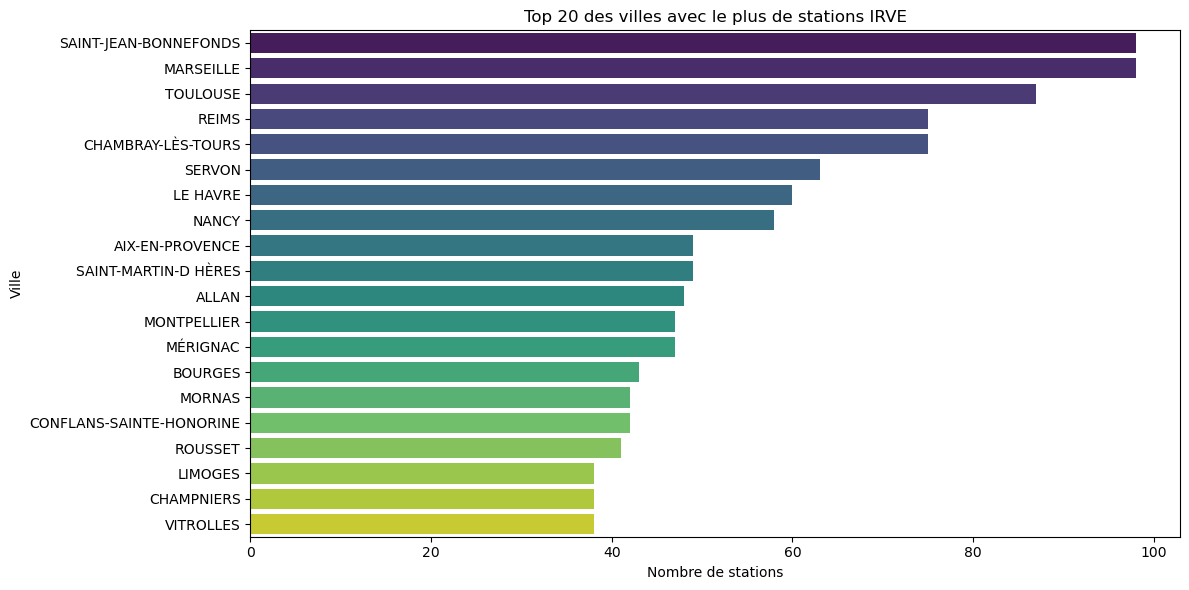

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_villes, 
            y=top_villes.columns[0],  # première colonne pour les villes
            x=top_villes.columns[1],  # deuxième colonne pour le nombre de stations
            hue='nb_stations',  # Ajout de hue avec la même variable que y
            palette='viridis')
plt.title("Top 20 des villes avec le plus de stations IRVE")
plt.xlabel("Nombre de stations")
plt.ylabel("Ville")
plt.tight_layout()
plt.show()

In [37]:
print(df[df['ville'].str.contains('PARIS', case=False, na=False)].shape)
print(df[df['ville'].str.contains('LYON', case=False, na=False)].shape)

(58, 47)
(20, 47)


In [39]:
import pandas as pd
import re

# Filtrer les stations concernant Paris et Lyon
pattern = r'(PARIS|LYON|750\d{2}|690\d{2})'  # Recherche des noms ou codes postaux

# Créer une colonne temporaire en majuscules pour la recherche
df['adresse_upper'] = df['adresse_station'].str.upper()

# Filtrer les enregistrements correspondants
stations_paris_lyon = df[
    df['adresse_upper'].str.contains(pattern, regex=True, na=False)
].copy()

# Extraire la ville et le code postal de l'adresse
stations_paris_lyon['ville_extracted'] = stations_paris_lyon['adresse_station'].apply(
    lambda x: re.findall(r'.*\b(\d{5})\s+([A-Za-zÀ-ÿ\- ]+)$', x)[0][1] 
    if re.search(r'\b\d{5}\s+[A-Za-zÀ-ÿ\- ]+$', x) 
    else None
)

# Afficher les résultats
print(f"Nombre de stations trouvées pour Paris/Lyon: {len(stations_paris_lyon)}")
print(stations_paris_lyon[['nom_station', 'adresse_station', 'ville_extracted']].head(20))

# Statistiques
print("\nRépartition :")
print(stations_paris_lyon['ville_extracted'].value_counts())

Nombre de stations trouvées pour Paris/Lyon: 247
                            nom_station  \
176                Fastned Emerainville   
177                Fastned Emerainville   
178                Fastned Emerainville   
179                Fastned Emerainville   
180                Fastned Emerainville   
181                Fastned Emerainville   
182                Fastned Emerainville   
183                Fastned Emerainville   
184                Fastned Emerainville   
185                Fastned Emerainville   
186                Fastned Emerainville   
187                Fastned Emerainville   
188                Fastned Emerainville   
189                Fastned Emerainville   
190                Fastned Emerainville   
191                Fastned Emerainville   
389  Shell Recharge 4 SAGS Rue de Lobau   
390  Shell Recharge 4 SAGS Rue de Lobau   
391  Shell Recharge 4 SAGS Rue de Lobau   
392  Shell Recharge 4 SAGS Rue de Lobau   

                                       adresse_

C:\Users\musta\AppData\Local\Temp\ipykernel_19028\2229951571.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['adresse_upper'].str.contains(pattern, regex=True, na=False)


### Code amélioré pour filtrer uniquement Paris et Lyon :

In [50]:
import pandas as pd
import re

# Créer une colonne normalisée pour la ville
def extract_ville(adresse):
    match = re.search(r'(\d{5})\s+([A-ZÀ-ÿ\- ]+)$', adresse.upper())
    if match:
        code_postal, ville = match.groups()
        if code_postal.startswith('75'):
            return 'PARIS'
        elif code_postal.startswith('69'):
            return 'LYON'
        return ville.strip()
    return None

df['ville_normalisee'] = df['adresse_station'].apply(extract_ville)

# Filtrer uniquement Paris et Lyon
stations_paris_lyon = df[df['ville_normalisee'].isin(['PARIS', 'LYON'])]

# Afficher les résultats
print(f"Stations à Paris: {len(stations_paris_lyon[stations_paris_lyon['ville_normalisee'] == 'PARIS'])}")
print(f"Stations à Lyon: {len(stations_paris_lyon[stations_paris_lyon['ville_normalisee'] == 'LYON'])}")

# Afficher un échantillon
print("\nExemples de stations à Paris:")
print(stations_paris_lyon[stations_paris_lyon['ville_normalisee'] == 'PARIS'][['nom_station', 'adresse_station']].head(10))

Stations à Paris: 36
Stations à Lyon: 226

Exemples de stations à Paris:
                                          nom_station  \
389                Shell Recharge 4 SAGS Rue de Lobau   
390                Shell Recharge 4 SAGS Rue de Lobau   
391                Shell Recharge 4 SAGS Rue de Lobau   
392                Shell Recharge 4 SAGS Rue de Lobau   
6260  Paris 10 - Indigo Parking Magenta Gare de l'Est   
6261  Paris 10 - Indigo Parking Magenta Gare de l'Est   
6262  Paris 10 - Indigo Parking Magenta Gare de l'Est   
6263  Paris 10 - Indigo Parking Magenta Gare de l'Est   
6264  Paris 10 - Indigo Parking Magenta Gare de l'Est   
6265  Paris 10 - Indigo Parking Magenta Gare de l'Est   

                           adresse_station  
389       4 SAGS Rue de Lobau, 75004 Paris  
390       4 SAGS Rue de Lobau, 75004 Paris  
391       4 SAGS Rue de Lobau, 75004 Paris  
392       4 SAGS Rue de Lobau, 75004 Paris  
6260  2 square Alban Satragne, 75010 Paris  
6261  2 square Alban Satragne

### Pour comprendre pourquoi Paris/Lyon n'apparaissent pas dans le top 20 :

In [43]:
# Vérifier si les stations sont fragmentées par arrondissements
paris_stations = stations_paris_lyon[stations_paris_lyon['ville_normalisee'] == 'PARIS']
lyon_stations = stations_paris_lyon[stations_paris_lyon['ville_normalisee'] == 'LYON']

print("\nRépartition par code postal à Paris:")
print(paris_stations['adresse_station'].str.extract(r'(75\d{3})')[0].value_counts().head(10))

print("\nRépartition par code postal à Lyon:")
print(lyon_stations['adresse_station'].str.extract(r'(69\d{3})')[0].value_counts().head(10))


Répartition par code postal à Paris:
0
75010    10
75012    10
75013     5
75004     4
75015     4
75018     3
Name: count, dtype: int64

Répartition par code postal à Lyon:
0
69500    18
69400    18
69220    17
69230    15
69120    13
69009    13
69633    11
69360    11
69720    11
69702    10
Name: count, dtype: int64


### comptage correct :

In [44]:
# Compter les stations par ville normalisée
top_villes_corrected = (
    df[df['ville_normalisee'].notna()]
    .groupby('ville_normalisee')
    .size()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name='nb_stations')
)

# Afficher le vrai top 20
print("\nTop 20 réel des villes avec le plus de stations:")
print(top_villes_corrected)


Top 20 réel des villes avec le plus de stations:
            ville_normalisee  nb_stations
0                       LYON          226
1                  MARSEILLE           98
2      SAINT-JEAN-BONNEFONDS           98
3                   TOULOUSE           87
4                      REIMS           75
5         CHAMBRAY-LÈS-TOURS           75
6                     SERVON           63
7                   LE HAVRE           60
8                      NANCY           58
9       SAINT-MARTIN-D HÈRES           49
10           AIX-EN-PROVENCE           49
11                     ALLAN           48
12               MONTPELLIER           47
13                  MÉRIGNAC           47
14                   BOURGES           43
15                    MORNAS           42
16  CONFLANS-SAINTE-HONORINE           42
17                   ROUSSET           41
18                  LA GARDE           38
19                 VITROLLES           38


In [8]:
# Chemin du fichier Excel de sortie
# Assurez-vous que le dossier "output" existe ou adaptez le chemin
output_excel_path = "c:/Code/projets_perso/projets/GeoChargeAnalytics/Data/mon_dataframe1.xlsx"

# Exportation du DataFrame vers Excel
df.to_excel(output_excel_path, index=False)

print(f"DataFrame exporté avec succès vers : {output_excel_path}")

DataFrame exporté avec succès vers : c:/Code/projets_perso/projets/GeoChargeAnalytics/Data/mon_dataframe1.xlsx


In [48]:
# Dans votre notebook ou script d'analyse :
problematic = df[df['ville_normalisee'].isna()]
if not problematic.empty:
    print("Adresses avec problèmes de parsing :")
    print(problematic[['adresse_station']].sample(10))
    
    # Sauvegarde pour analyse manuelle
    problematic.to_csv('./problematic_addresses1.csv')

Adresses avec problèmes de parsing :
                                         adresse_station
2899         Place de l'Eglise, 28260 LA CHAUSSEE-D'IVRY
7323   Avenue du Camp Dolent, 76700 Gonfreville-l'Orcher
3400                    Place Danton, 08 Bogny sur Meuse
2889                    Rte de Louvois, 51 ST MARTIN/PRE
2887                        Rue de POIX, 51 Saint Memmie
5082   Avenue du Passage du Bois 156, 85180 Les Sable...
6720      3 avenue du Portou, 64990 Saint-Pierre-d'Irube
5444              Boulevard de Tilsit, 95290 L'Isle-Adam
11013               25 Rue Des Sayes, 38080 Isle d'Abeau
5443              Boulevard de Tilsit, 95290 L'Isle-Adam


In [49]:
pb_df = pd.read_csv('problematic_addresses1.csv')
pb_df

,Unnamed: 0,contact_amenageur,contact_operateur,nom_amenageur,nom_operateur,telephone_operateur,siren_amenageur,raccordement,nom_enseigne,id_station_itinerance,id_station_local,nom_station,implantation_station,adresse_station,code_insee_commune,coordonneesXY,nbre_pdc,id_pdc_itinerance,id_pdc_local,puissance_nominale,prise_type_ef,prise_type_2,prise_type_combo_ccs,prise_type_chademo,prise_type_autre,gratuit,tarification,paiement_autre,paiement_acte,paiement_cb,condition_acces,reservation,horaires,accessibilite_pmr,restriction_gabarit,station_deux_roues,date_mise_en_service,observations,date_maj,cable_t2_attache,num_pdl,latitude,longitude,nom_commune,ville_guess,ville_match,code_postal,ville,ville_normalisee,adresse_upper
0,403,customerservice@shellrecharge.com,customerservice@shellrecharge.com,Shell Recharge,Shell Recharge,+(33)-(9)-77554349,NaN,NaN,Shell Gonfreville L'O - Le Havre,FRSHEE405,FRSHEE405,Shell Gonfreville L'O - Le Havre,Station dédiée à la recharge rapide,"9 route d'Oudalle, 76700 Gonfreville l'Orcher",00nan,"[0.21080800,49.50314500]",4,FRSHEE4051,FRSHEE4051,150,False,False,True,False,False,False,NaN,NaN,True,True,Accès réservé,False,24/7,Accessibilité inconnue,inconnu,False,2024-05-21,NaN,2025-06-05,False,NaN,49.503145,0.210808,NaN,76700 GONFREVILLE L'ORCHER,False,76700.0,GONFREVILLE LE ORCHER,NaN,"9 ROUTE D'OUDALLE, 76700 GONFREVILLE L'ORCHER"
1,404,customerservice@shellrecharge.com,customerservice@shellrecharge.com,Shell Recharge,Shell Recharge,+(33)-(9)-77554349,NaN,NaN,Shell Gonfreville L'O - Le Havre,FRSHEE405,FRSHEE405,Shell Gonfreville L'O - Le Havre,Station dédiée à la recharge rapide,"9 route d'Oudalle, 76700 Gonfreville l'Orcher",00nan,"[0.21080800,49.50314500]",4,FRSHEE4052,FRSHEE4052,125,False,False,False,True,False,False,NaN,NaN,True,True,Accès réservé,False,24/7,Accessibilité inconnue,inconnu,False,2024-05-21,NaN,2025-06-05,False,NaN,49.503145,0.210808,NaN,76700 GONFREVILLE L'ORCHER,False,76700.0,GONFREVILLE LE ORCHER,NaN,"9 ROUTE D'OUDALLE, 76700 GONFREVILLE L'ORCHER"
2,405,customerservice@shellrecharge.com,customerservice@shellrecharge.com,Shell Recharge,Shell Recharge,+(33)-(9)-77554349,NaN,NaN,Shell Gonfreville L'O - Le Havre,FRSHEE405,FRSHEE405,Shell Gonfreville L'O - Le Havre,Station dédiée à la recharge rapide,"9 route d'Oudalle, 76700 Gonfreville l'Orcher",00nan,"[0.21080800,49.50314500]",4,FRSHEE4053,FRSHEE4053,150,False,False,True,False,False,False,NaN,NaN,True,True,Accès réservé,False,24/7,Accessibilité inconnue,inconnu,False,2024-05-21,NaN,2025-06-05,False,NaN,49.503145,0.210808,NaN,76700 GONFREVILLE L'ORCHER,False,76700.0,GONFREVILLE LE ORCHER,NaN,"9 ROUTE D'OUDALLE, 76700 GONFREVILLE L'ORCHER"
3,406,customerservice@shellrecharge.com,customerservice@shellrecharge.com,Shell Recharge,Shell Recharge,+(33)-(9)-77554349,NaN,NaN,Shell Gonfreville L'O - Le Havre,FRSHEE405,FRSHEE405,Shell Gonfreville L'O - Le Havre,Voirie,"9 route d'Oudalle, 76700 Gonfreville l'Orcher",00nan,"[0.21080800,49.50314500]",4,FRSHEE4054,FRSHEE4054,22,False,True,False,False,False,False,NaN,NaN,True,True,Accès réservé,True,24/7,Accessibilité inconnue,inconnu,False,2024-05-21,NaN,2025-06-05,False,NaN,49.503145,0.210808,NaN,76700 GONFREVILLE L'ORCHER,False,76700.0,GONFREVILLE LE ORCHER,NaN,"9 ROUTE D'OUDALLE, 76700 GONFREVILLE L'ORCHER"
4,407,customerservice@shellrecharge.com,customerservice@shellrecharge.com,Shell Recharge,Shell Recharge,+(33)-(9)-77554349,NaN,NaN,Shell Criquetôt - Le Havre,FRSHEE182,FRSHEE182,Shell Criquetôt - Le Havre,Station dédiée à la recharge rapide,"Rue de la Victoire 1914-1918, 76280 Criquetot ...",00nan,"[0.26538000,49.64421600]",7,FRSHEE1821,FRSHEE1821,150,False,False,True,False,False,False,NaN,NaN,True,True,Accès réservé,False,24/7,Accessibilité inconnue,inconnu,False,2023-08-24,NaN,2025-06-05,False,NaN,49.644216,0.265380,NaN,NaN,False,NaN,NaN,NaN,"RUE DE LA VICTOIRE 1914-1918, 76280 CRIQUETOT ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [52]:
pb_df.shape

(458, 50)

### Correction au cas par cas des enregistrements problématiques

L'exploration visuelle des données dans le fichier excel exportée a permis d'identifier les problèmes d'extractions des villes:
* les villes qui contiennent dans leurs noms au moins une **apostrophe** telles que la ville **ISLE D'ABEAU**, n'ont pas été extraites.
* egalement pour les adresses contenant des erreurs dans les codes postaux :
  * le code postal écrit deux fois de suite telles que **AIRE DE PAYS DE BRIVE, A89, 19600 19600 SAINT-PANTALÉON-DE-LARCHE** dans ce cas la ville est extraite avec erreur.
  * le code postal ne contient pas 5 chiffres ou est faux telles que **ZAC DE LA VARIZELLE, 4240 SAINT-CHAMOND** , **2 PLACE DE L'HOTEL DE VILLE, 51 SUIPPES** , **30 RUE CHANZY, 5& VERZY**
  * le code de l'autoroute est écrit dans l'adresse séparement par une virgule ou attachée au nom de la ville (village) telles que **AIRE DE MAS D\'AGENAIS, A62, 47430 LE MAS-D\'AGENAIS**,
  * le code postal a été ommis carrémment :**RUE PRINCIPALE, BOURNAN BOURNAN**
* les adresses contenant le code de l'autoroute où se situe la borne ce qui fausse la succession habituelle "code postal/nom de la ville" telles que **ASF AIRE DE ROUILLE PAMPROUX NORD, 79800 A10 PAMPROUX**, **ASF AIRE DE CHAVAGNES EN PAILLERS, 85250 A83 CHAVAGNES EN PAILLERS**, **ASF AIRE DE TOULOUSE SUD NORD, 31450 A61 DEYME**; dans ces cas la ville est extraite avec erreur. 

### Verification de l'ajot correct de la colonne 'department'

In [14]:
df = load_data("c:/Code/Projets_perso/projets/GeoChargeAnalytics/data/raw/1-irve-statique.csv")
df = clean_data(df)
df = extract_departement(df)  # <-- Ici, la colonne departement est ajoutée

# Analyse par zones urbaines
CENTROIDS = {
    'paris': [48.8566, 2.3522],
    'lyon': [45.75, 4.85],
    'marseille': [43.3, 5.4],
    'bordeaux': [44.84, -0.58],
    'idf': [48.8, 2.4],
    'autoroutes': [46.5, 2.5]  # Centre géographique pour visualisation
}
villes = ['paris', 'lyon', 'marseille', 'bordeaux', 'idf']
for ville in villes:
    df_ville = filter_by_ville(df, ville)  # <-- Utilise la colonne departement
    if df_ville.empty:
        continue
    dossier_docs = "c:/Code/Projets_perso/projets/GeoChargeAnalytics/docs"
    os.makedirs(dossier_docs, exist_ok=True)
    output_file = os.path.join(dossier_docs, f'heatmap_{ville}.html')
    generate_heatmap(
        df_ville,
        center=CENTROIDS[ville],
        output_file=output_file,
        radius=12 if ville in ['paris', 'lyon'] else 8
    )






In [15]:
df.head()

,contact_amenageur,contact_operateur,nom_amenageur,nom_operateur,telephone_operateur,siren_amenageur,raccordement,nom_enseigne,id_station_itinerance,id_station_local,...,date_maj,cable_t2_attache,num_pdl,latitude,longitude,ville_normalisee,autoroute,code_postal,ville,departement
0,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,...,2025-06-05,False,NaN,49.072321,4.789089,Valmy,A4,51800,Valmy,51
1,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,...,2025-06-05,True,NaN,49.072321,4.789089,Valmy,A4,51800,Valmy,51
2,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,...,2025-06-05,False,NaN,49.072321,4.789089,Valmy,A4,51800,Valmy,51
3,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Valmy-Orbeval,FRFASE33114,FRFASE33114,...,2025-06-05,True,NaN,49.072321,4.789089,Valmy,A4,51800,Valmy,51
4,support@fastned.nl,support@fastned.nl,Fastned France,Fastned France,+(33)-(18)-4710062,853300010.0,Direct,Fastned Aire de Jonchets - La Grande Paroisse,FRFASE33021,FRFASE33021,...,2025-06-05,False,NaN,48.426030,2.928826,Seine-Et-Marne,A5,77130,Seine-Et-Marne,77


In [17]:
df['departement'].unique()

array(['51', '77', '95', '59', '71', '29', '38', '62', '54', '27', '91',
       '16', '74', '34', '69', '24', '46', '78', '57', '67', '26', '03',
       '21', '80', '56', '42', '73', '10', '25', '92', '76', '61', '75',
       '31', '33', '40', '28', '17', '35', '13', '22', '39', '64', '86',
       '63', '52', '53', '45', '02', '84', '72', '01', '83', '14', '87',
       '48', '36', '89', '55', '68', '49', '90', '85', '04', '41', '19',
       '50', '44', '18', '66', '12', '79', '47', '82', '06', nan, '11',
       '09', '37', '30', '88', '08', '70', '20', '81', '60', '32', '15',
       '43', '05', '94', '93', '58', '65', '23'], dtype=object)

In [18]:
# Chemin du fichier Excel de sortie
# Assurez-vous que le dossier "output" existe ou adaptez le chemin
output_excel_path = "c:/Code/projets_perso/projets/GeoChargeAnalytics/Data/df_pour_verif_dep.xlsx"

# Exportation du DataFrame vers Excel
df.to_excel(output_excel_path, index=False)

print(f"DataFrame exporté avec succès vers : {output_excel_path}")

DataFrame exporté avec succès vers : c:/Code/projets_perso/projets/GeoChargeAnalytics/Data/df_pour_verif_dep.xlsx
